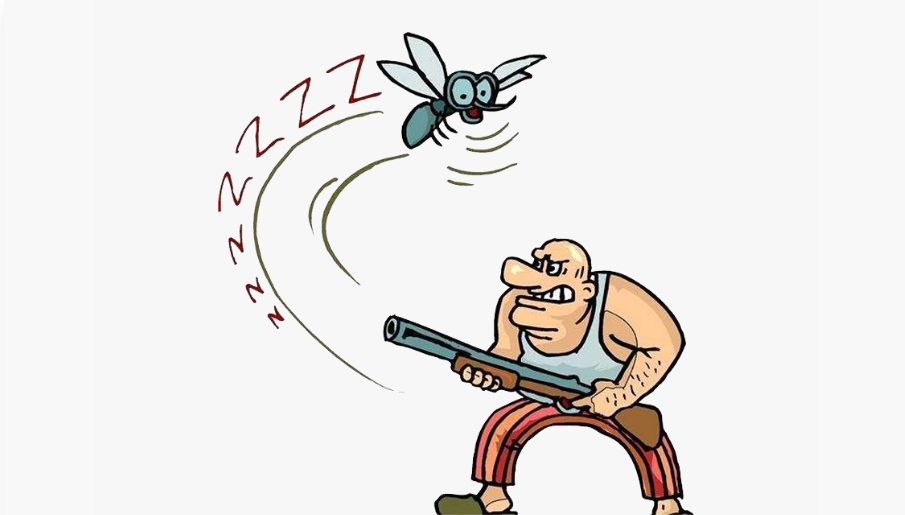

# Introduction

In the United States, an average of seven cases of Eastern Equine Encephalitis (EEE) are reported to the CDC annually. In 2019, however, the CDC confirmed 38 cases of EEE and 15 deaths. It has a fatality rate estimated to be around 33%, with many survivors experiencing permanent neurological damage, and there is currently no effective treatment. Other arboviruses, such as West Nile Virus (WNV), are also prevalent and deadly.

Massachusetts was one of the most impacted states of the 2019 outbreak, with 12 reported cases and six deaths. Many towns in Massachusetts cancelled outdoor activities and imposed curfews during hours when mosquitos were most active with the hope of mitigating potential exposures, but such guidelines were reactive, not proactive. With fears of new, emerging arboviruses being more virulent, and in light of the recent outbreak of SARS-CoV-2, society should be better prepared to predict potential outbreaks and respond to them effectively before they happen.

This notebook demonstrates use of ARIMA models (Auto vs. manual) to forecast mosquito outbreaks based on data from Massachusetts.

Key takeaways:

* More cases are seen during the summer period.
* The data is non-stationary and forecasting benefits when we differentiatate the case count.
* A seasonal ARIMA model (SARIMAX) fits the data well.
* Using AutoARIMA and CV we can improve the baseline model significantly.

Sources:

https://alkaline-ml.com/pmdarima/tips_and_tricks.html <br>
https://alkaline-ml.com/pmdarima/usecases/sun-spots.html <br>
https://alkaline-ml.com/pmdarima/auto_examples/model_selection/example_cross_val_predict.html

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima import arima
from pmdarima import model_selection
from pmdarima import pipeline
from pmdarima import preprocessing
from pmdarima.datasets._base import load_date_example
from pmdarima.utils import tsdisplay
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Load the data
mosquito_totals = pd.read_csv('../input/massachusetts-arbovirus-survalliance-data-201419/mosquito_totals.csv')

# Convert dates
mosquito_totals['Collection Date'] = pd.to_datetime(mosquito_totals['Collection Date'])

# Sort by Collection date
mosquito_totals = mosquito_totals.sort_values(by='Collection Date', ascending=True).reset_index()

print("Total number of observations:", len(mosquito_totals))

mosquito_totals.head()

In [ ]:
# Print a random mosquito bite as a sample
sample_index = 25
print(mosquito_totals.iloc[sample_index])

# EDA

Let's start off by investating the data a bit. The data is a recorded list of all registered mosquito bites and comes with the following columns:

* County: The county the bite was registered in.
* Town: The town the bite was registered in.
* Collection Date: The day the person was bitten.
* Specices: The mosquito species that made the bite.
* Virus: The type of pathological infection that was detected following the bite.

The following plots are simple illustrations of the data.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

mosquito_cases = pd.DataFrame(mosquito_totals.groupby(['Collection Date']).Virus.count()).reset_index()
mosquito_cases.columns = ['Date', 'Cases']

fig = go.Figure()
fig.add_trace(go.Scatter(x=mosquito_cases['Date'],
                         y=mosquito_cases['Cases'],
                         mode='lines',
                         name='Mosquito cases',
                         showlegend=True))
fig.update_layout(title='New confirmed cases per year',
                   xaxis_title='Year',
                   yaxis_title='New cases')
fig.show()

In [ ]:
mosquito_totals['Year'] = mosquito_totals['Collection Date'].dt.year
mosquito_per_year = pd.DataFrame(mosquito_totals.groupby(['Year'])['Virus'].count()).reset_index()
mosquito_per_year.columns = ['Year', 'Cases']
fig = px.bar(mosquito_per_year, x='Year', y='Cases')
fig.update_layout(title='Total confirmed cases per year',
                   xaxis_title='Year',
                   yaxis_title='New cases')
fig.show()

In [ ]:
mosquito_virus = mosquito_totals.groupby(['Year', 'Virus'], as_index=False).count()
mosquito_virus = mosquito_virus.iloc[:,:3]
mosquito_virus.columns = ['Year', 'Virus', 'Cases']
fig = px.bar(mosquito_virus, x="Year", y="Cases", color="Virus", title="Confirmed cases by virus")
fig.show()

In [ ]:
mosquito_virus_sum = mosquito_virus.groupby(['Year', 'Virus'], as_index=False).agg('sum')
fig = px.line(mosquito_virus_sum, x="Year", y="Cases", color='Virus')
fig.update_layout(title='New EEE and WNV cases per year',
                   xaxis_title='Year',
                   yaxis_title='New cases')
fig.show()

# Examining the timeseries

Time series data is a bit different from traditional machine learning in the sense that it’s temporally sensitive. That means the larger our test set, the higher we would expect our error to be for later forecasts, since our model won’t be able to effectively forecast for too many periods into the future.

Here, we’ll take the first 2750 samples for training, and leave the last 70 as our test set.

We use the tsdisplay() function to visalize our data, take a look at the auto-correlation plot, and see the histogram of values.

In [ ]:
# Remake the mosquito cases dataframe for clarity
mosquito_cases = pd.DataFrame(mosquito_totals.groupby(['Collection Date']).Virus.count()).reset_index()
mosquito_cases.columns = ['Date', 'Cases']

# Set date column to index
mosquito_cases.set_index('Date',inplace=True)

train_size = int(0.9*len(mosquito_cases))
y_train, y_test = train_test_split(mosquito_cases, train_size=train_size)

# Show the ACF and frequency plot of the data
tsdisplay(y_train, lag_max=90)

Reading this plot can give us several pieces of information:

* We are looking at a seasonal time series. Our apriori knowledge of the dataset (mosquito bites varies by time of year) and the fact that the ACF has a spike around lag=12 informs us that this data has a seasonal periodicity of m=12.
* There seems to be some significant data skew, looking at the histogram. It is very zero-inflated. A lot of the statistical techniques used in time series modeling behave better when the data is normally distributed, so this may be something to look into. This can possibilty be archived by differentiating the cases values to make the data stationary, as we'll see shortly.

Differentiating the cases will also likely make the time series more stationary. A series is defined as stationary when its mean, variance and auto-correlation, etc., are constant over time. Many time-series methods perform better when a time-series is stationary, since forecasting values becomes a far easier task for a stationary time series. ARIMAs that include differencing (i.e., d > 0) assume that the data becomes stationary after differencing. This is called difference-stationary. Auto-correlation plots are an easy way to determine whether your time series is sufficiently stationary for modeling.

Look above and see, that our plot does not appear stationary, so our model will likely need a differencing term.

# Understanding P, D, and Q

ARIMA models are made up of three different terms:

**P:** The order of the auto-regressive (AR) model (i.e., the number of lag observations). A time series is considered AR when previous values in the time series are very predictive of later values. An AR process will show a very gradual decrease in the ACF plot.

**D:** The degree of differencing.

**Q:** The order of the moving average (MA) model. This is essentially the size of the “window” function over your time series data. An MA process is a linear combination of past errors.

Often times, ARIMA models are written in the form ARIMA(p,d,q), where a model with no differencing term, e.g., ARIMA(1,0,12), would be an ARMA (made up of an auto-regressive term and a moving average term, but no integrative term, hence no “I”). One of the challenges of timeseries modelling with ARIMA is finding the hyperparameters P, D, and Q. Fortunately, the library offers a AutoARIMA() function that can estimate these values for us, as we'll see next.

# Fitting a baseline model

Before we start manipulating our data, let’s examine what would happen if we just fit a model straight out of the box:

In [ ]:
baseline_model = pm.auto_arima(y_train, suppress_warnings=True, start_p=0, start_q=0,
                      max_p=5, max_q=5, stepwise=True, trace=True, seasonal=True, m=12)

Examining the summary gives us:

In [ ]:
baseline_model.summary()

Note that the AutoARIMA() produces a seasonal arima model (SARIMAX) with parameters p=2, d=1 and q=1. These are calculated by performing a stepwise search to minimize the AIC score (see above). Akaike’s Information Criterion (AIC), which was useful in selecting predictors for regression, is also useful for determining the order of an ARIMA model. A lower AIC is always better, hence the model ended up with (2,1,1).

We used 222 oberservations to train this model and ended with an AIC=1452. Since d=1, the model suggests that differentiating the case count could be beneficial when making forecasting, thus we expext our model to perform better over more normal data (stationary).

For fun, let's use the baseline model to make forecasts already on the test set.

In [ ]:
# Make predictions using naive model
predictions = baseline_model.predict(n_periods=y_test.shape[0])

# Plot baseline mode
fig = go.Figure()
x = np.arange(y_test.shape[0])
fig.add_trace(go.Scatter(x=x, y=y_test['Cases'], mode='markers', name='Actual cases', showlegend=True))
fig.add_trace(go.Scatter(x=x, y=predictions, mode='lines', name='Predicated cases'))

fig.update_layout(title='Baseline naive model for m=12',
                   xaxis_title='Days',
                   yaxis_title='New cases')

fig.show()

# Transforming the data

Since we expect our model to perform better over more normal data, let’s experiment with log transformations and the Box-Cox transformation, each of which is provided as an endogenous transformer in the Pmdarima package.

In [ ]:
from pmdarima.preprocessing import LogEndogTransformer

y_train_log, _ = LogEndogTransformer(lmbda=1e-6).fit_transform(y_train)
tsdisplay(y_train_log, lag_max=100)

The log transformation didn’t seem to help too much. In fact, it seems like it just shifted the skew to the other tail. Let’s try the Box-Cox transformation. When .fit() is called, it will learn the lambda transformation parameter:

In [ ]:
from pmdarima.preprocessing import BoxCoxEndogTransformer

y_train_bc, _ = BoxCoxEndogTransformer(lmbda2=1e-6).fit_transform(y_train)
tsdisplay(y_train_bc, lag_max=100)

The frequency bins still does not still not look normal. Let's try manually differentiating the data, so that we create a new column with the difference between every observations. This will reduce the spikyness of the curve and make the data more stationary. Hopefully, this will produce a more normal frequency distribution.

In [ ]:
# Make a column containing the difference in cases for train and test set
# We shift by 12 since m=12

pd.set_option('mode.chained_assignment', None)
y_train['Cases Difference'] = y_train['Cases'] - y_train['Cases'].shift(12)
y_test['Cases Difference'] = y_test['Cases'] - y_test['Cases'].shift(12)

# Fill missing values (the first 12)
y_train = y_train.fillna(0)
y_test = y_test.fillna(0)

# Display the new data
pm.tsdisplay(y_train['Cases Difference'], lag_max=90, show=True)

Let's visualize the two times we have now. First is a line showing new cases, and the second is the scalar difference between cases each day.

In [ ]:
x = np.arange(y_train.shape[0])

fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Scatter(x=x, y=y_train['Cases'], name="New cases"), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=y_train['Cases Difference'], name="New cases differentiated"), row=1, col=2)

fig.update_layout(title_text="Test samples count vs. differentiated")
fig.show()

More normal data is observed by the second plot, so we'll stick for that for now. Recall that AutoARIMA() found d=1, so differentiating the data is a good idea in this case.

# Finding the best model (CV)

Cross-validation is a model validation technique for assessing how the results of a statistical analysis will generalize to an independent data set. In this case, we want to know how well our ARIMA model can predict the future basically (new cases of mosquito bites). Scitit-learn offers various methods for cross-validating normal regressions and with Pmdarmia, we can cross-validate our time series models as well.

Let's create two different models know: One using default ARIMA() parameters (1, 0, 1) and one using those found by AutoARIMA (2, 1, 1).

In [ ]:
# Create a default ARIMA model
model1 = pm.ARIMA(order=(1, 0, 1),
               seasonal_order=(1, 0, 1, 12),
               suppress_warnings=True)

# Create the one we found previously using AutoARIMA
model2 = pm.ARIMA(order=(2, 1, 1),
               seasonal_order=(0, 0, 1, 12),
               suppress_warnings=True)

# Set the CV strategy
cv = model_selection.SlidingWindowForecastCV(window_size=100, step=24, h=1)

# Run CV and get scores for each model
print("Creating model 1 (1, 0, 1): \n")
model1_cv_scores = model_selection.cross_val_score(model1, y_train['Cases Difference'], scoring='smape', cv=cv, verbose=2)
print()
print("Creating model 2 (2, 1, 1): \n")
model2_cv_scores = model_selection.cross_val_score(model2, y_train['Cases Difference'], scoring='smape', cv=cv, verbose=2)
print()

print("Model 1 CV scores: {}".format(model1_cv_scores.tolist()))
print("Model 2 CV scores: {}".format(model2_cv_scores.tolist()))

# Pick the with lowest mean error rate
m1_average_error = np.average(model1_cv_scores)
m2_average_error = np.average(model2_cv_scores)
errors = [m1_average_error, m2_average_error]
models = [model1, model2]

# Print out the answer
better_index = np.argmin(errors)  # type: int
print("Lowest average SMAPE: {} (model{})".format(errors[better_index], better_index + 1))
print("Best model: {}".format(models[better_index]))

# Making mosquito forecasts (CV)

Let's use the model we just found, which is a SARIMAX(2,1,1) with m=12, to make forecasts about new mosquito bites.

Unlike normal CV, time series CV might have different folds (windows) forecasting the same time step. After all forecast windows are made, we build a matrix of y x n_folds, populating each fold’s forecasts, and then we average each time step’s forecasts to end up with our final prediction results. So we with averaging strategy to "median".

In [ ]:
from pmdarima import model_selection

# Create the model
model = pm.ARIMA(order=(2, 1, 1),
               seasonal_order=(0, 0, 1, 12),
               suppress_warnings=True)

# Set the CV strategy
cv = model_selection.SlidingWindowForecastCV(window_size=100, step=1, h=4)

# Make predictions
predictions = model_selection.cross_val_predict(model, y_train['Cases Difference'], cv=cv, verbose=1, averaging="median")

# Plot the predictions on the training data
x_axis = np.arange(y_train.shape[0])
n_test = predictions.shape[0]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_axis, y=y_train['Cases Difference'], name='Actual cases'))
fig.add_trace(go.Scatter(x=x_axis[-n_test:], y=predictions, name='Forecasted cases'))
fig.update_layout(title='Cross-validated mosquito forecasts', xaxis_title='Days', yaxis_title='New cases')
fig.show()

Not bad, the model we found seems to do a good job at forecasting mosquito bites on the training data. Note that it starts off slow at the 0-100 interval, then fluctuatats after 150 as the number of new bites recoded every day increases. This plot is consistent with our discovery during EDA as the number of recorded mosquito cases as increased rapidly in 2018 and 2019 compared to the years ago. Perhaps we could get a even better model by only examining the data from 2018 and onwards.

Let's make a prediction on the never-seen-before test set.

# Making mosquito forecasts (unseen data)

We'll now train the same ARIMA model as before using the best parameters obtained and have it forecast on unseen test data. The code below should not contain any surprise, as it is mostly a reprise of what's been done before.

Though notice that the model gets through for a loop at the spike around day 4, where the number of cases suddently increases to 16 and drops to 0 the next day.

In [ ]:
# Remove the first 12 zero samples
y_test = y_test.iloc[12:]

# Create the best model we found
model = pm.ARIMA(order=(2, 1, 1),
                 seasonal_order=(0, 0, 1, 12),
                 suppress_warnings=True)

# Fit on the difference score
model.fit(y_train['Cases Difference'])

# Make predictions
predictions = model.predict(n_periods=y_test.shape[0])

# Plot the result
x = np.arange(y_test.shape[0])
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y_test['Cases Difference'], mode='markers', name='Actual cases', showlegend=True))
fig.add_trace(go.Scatter(x=x, y=predictions, mode='lines', name='Forecasted cases'))

fig.update_layout(title='Forecasting 16 unseen mosquito cases',
                   xaxis_title='Days',
                   yaxis_title='New cases')
fig.show()

And here's the model's summary:

In [ ]:
model.summary()

Let's plot the predictions together with the original training data. The predicts should continue the trend observed in the training data, but fall off slightly, as we predicting from the summer and onwards (recall that the number of mosquito cases wear off after August).

In [ ]:
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import normaltest

# Set axis
x = np.arange(y_train.shape[0] + predictions.shape[0])
fig, axes = plt.subplots(2, 1, sharex=False, figsize=(10,10))

# Make y_test an array
y_test_arr = np.array(y_test['Cases Difference'])

# Plot the forecasts
axes[0].plot(x[:y_train.shape[0]], y_train, c='b')
axes[0].plot(x[y_train.shape[0]:], predictions, c='g')
axes[0].set_xlabel(f'RMSE = {np.sqrt(mse(y_test_arr, predictions)):.3f}')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('New cases +/-')
axes[0].set_title('Forecasting new mosquito cases')

# Plot the residuals
resid = y_test_arr - predictions
_, p = normaltest(resid)
axes[1].hist(resid, bins=15)
axes[1].axvline(0, linestyle='--', c='r')
axes[1].set_xlabel('New cases +/-')
axes[1].set_ylabel('Residaul strength')
axes[1].set_title(f'Residuals (p={p:.3f})')

plt.tight_layout()
plt.show()

Notice that we are not using the SMAPE (symmetric mean absolute percentage error) as we normally might, because our time series contains zeros. When the actual or forecasted value is zero, SMAPE is known to produce misleadingly large error terms. Instead, we’re using the RMSE.

The first image shows the training data and our prediction as a continous line graph.

The second image shows the distribution of the residuals. The appear somewhat normally distributed and at least much more than the first residual plot we made using the raw new case numbers and not the differentated version.

# Conclusion

We have demonstrated how the number of mosquito cases in Massachusetts can be forecasted using a SARIMAX (seasonal ARIMA) model. We used AutoARIMA to find the best model parameters and discovered via frequency plots that it's a good idea to differentiate the raw count. AutoARIMA also told us that by setting d=1.